# Matteo_Challenge1: Hand-Crafted Solution

## Import libraries

In [2]:
import os
import random
from datetime import datetime

import splitfolders

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from keras.models import load_model
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
# Checking tensorflow version
tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.10.0


In [4]:
# Setting seed for reproducibility
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

## Dataset Splitting


In [4]:
# Splitting the main dataset into train and val
dataset_dir = 'Dataset'

if not(os.path.exists('../datasetWithoutTest')) :
    print('splitting into train and validation...')
    splitfolders.ratio('dataset', output='datasetWithoutTest', seed=seed, ratio=(0.8, 0.2))

# Setting dataset directories
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')

splitting into train and validation...


## Model Parameters and Classes Weights

In [5]:
labels = ['Species1',      # 0
          'Species2',      # 1
          'Species3',      # 2
          'Species4',      # 3
          'Species5',      # 4
          'Species6',      # 5
          'Species7',      # 6
          'Species8']      # 7

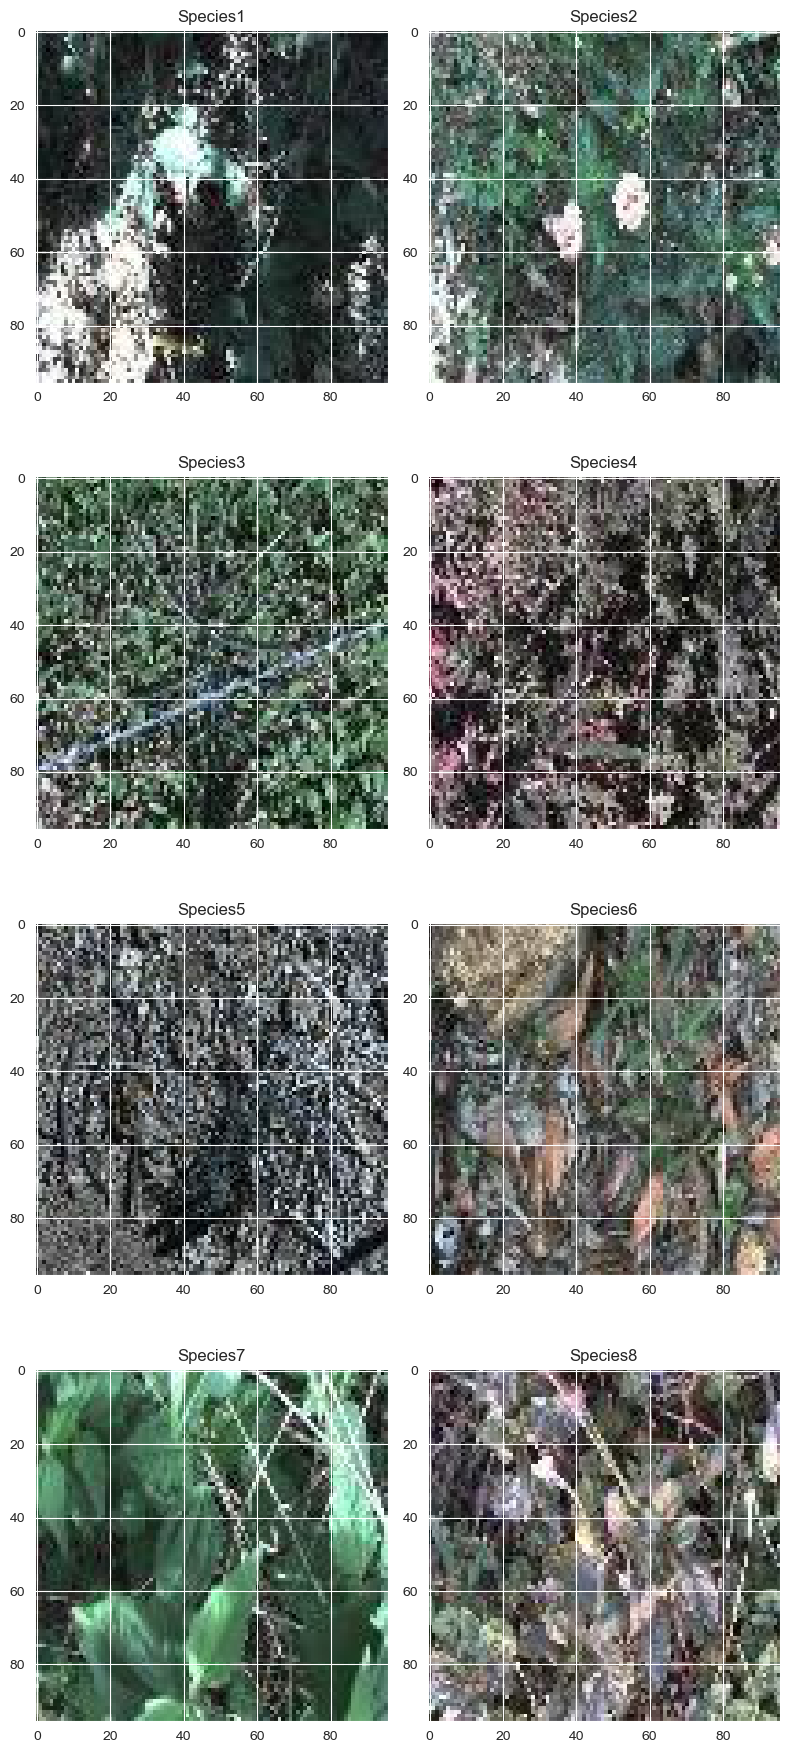

In [7]:
dataset_dir = 'Dataset'

num_row = 4
num_col = 2
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,9*num_col))
for i in range(num_row*num_col):
    if i < 8:
        class_imgs = next(os.walk('{}/{}'.format(dataset_dir, labels[i])))[2]
        class_img = class_imgs[0]
        img = Image.open('{}/{}/{}'.format(dataset_dir, labels[i], class_img))
        ax = axes[i//num_col, i%num_col]
        ax.imshow(np.array(img))
        ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

## Model Parameters and Metadata

In [8]:
# Input Parameters
img_w = 96
img_h = 96
input_shape = (96, 96, 3)
classes = 8

# Training Parameters
epochs = 90
batch_size = 64
reg_rate = 0.001

# Earlystopping Parameters
early_stopping = False
patience_epochs = 9

In [12]:
training_dir = "datasetWithoutTest/train"
validation_dir = "datasetWithoutTest/val"
# This calculate the weights for all the classes
# by counting the number of images for each class
# and dividing by the number of total images
category_weight = {}
elements_per_class = {}

for i in range(classes):
    category_weight[i] = 0.0

for i in range(classes):
    elements_per_class[i] = 0

_, classes_directories, _ = next(os.walk(training_dir))

for img_class in classes_directories:
    class_dir = training_dir + '/' + str(img_class)
    _, _, files = next(os.walk(class_dir))
    elements_per_class[labels.index(img_class)] = len(files)

total_images = sum(elements_per_class.values())

for i in category_weight.keys():
    category_weight[i] = total_images / (classes * elements_per_class[i])

## Data Augmentation

In [31]:
train_data_gen = ImageDataGenerator()
valid_data_gen = ImageDataGenerator()

In [32]:
train_gen = train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=labels,
                                                       batch_size=batch_size,
                                                       shuffle=True,
                                                       seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96, 96),
                                               color_mode='rgb',
                                               classes=labels,
                                               batch_size=batch_size,
                                               shuffle=False,
                                               seed=seed)

Found 2829 images belonging to 8 classes.
Found 713 images belonging to 8 classes.


In [33]:
print("Assigned labels")
print(train_gen.class_indices)
print()
print("Target classes")
print(train_gen.classes)

Assigned labels
{'Species1': 0, 'Species2': 1, 'Species3': 2, 'Species4': 3, 'Species5': 4, 'Species6': 5, 'Species7': 6, 'Species8': 7}

Target classes
[0 0 0 ... 7 7 7]


In [34]:
def get_next_batch(generator):
    batch = next(generator)

    image = batch[0]
    target = batch[1]

    print("(Input) image shape:", image.shape)
    print("Target shape:",target.shape)

    # Visualize only the first sample
    image = image[0]
    target = target[0]
    target_idx = np.argmax(target)
    print()
    print("Categorical label:", target)
    print("Label:", target_idx)
    print("Class name:", labels[target_idx])
    fig = plt.figure(figsize=(6, 4))
    plt.imshow(np.uint8(image))

    return batch

(Input) image shape: (64, 96, 96, 3)
Target shape: (64, 8)

Categorical label: [0. 0. 0. 1. 0. 0. 0. 0.]
Label: 3
Class name: Species4


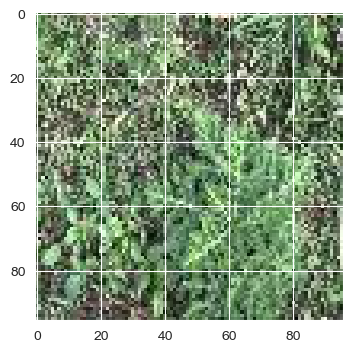

In [35]:
# Get a sample from dataset and show info
_ = get_next_batch(train_gen)

## Data Augmentation


Rotation: {'theta': -7.527592869158251, 'tx': 0, 'ty': 0, 'shear': 0, 'zx': 1, 'zy': 1, 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 

Shift: {'theta': 0, 'tx': 0, 'ty': 38, 'shear': 0, 'zx': 1, 'zy': 1, 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 

Zoom: {'theta': 0, 'tx': 0, 'ty': 0, 'shear': 0, 'zx': 0.9247240713084175, 'zy': 1.2704285838459497, 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 

Flip: {'theta': 0, 'tx': 0, 'ty': 0, 'shear': 0, 'zx': 1, 'zy': 1, 'flip_horizontal': 1, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 

Flip: {'theta': 0, 'tx': 0, 'ty': 0, 'shear': 0, 'zx': 1, 'zy': 1, 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 



Text(0.5, 1.0, 'Rescaled')

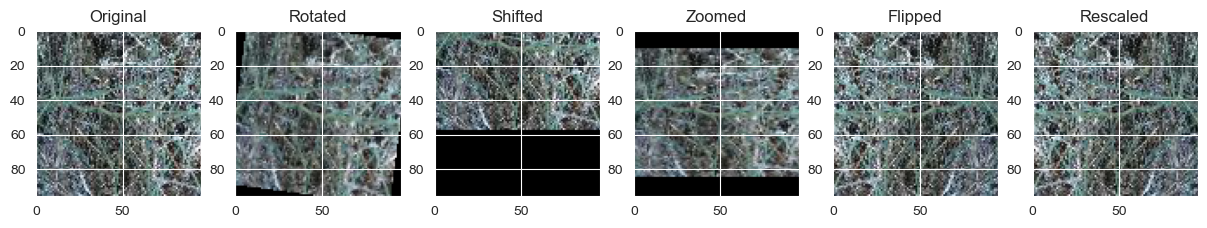

In [38]:
# Create some augmentation examples
# Get sample image
image = next(train_gen)[0][4]

# Create an instance of ImageDataGenerator for each transformation
rot_gen = ImageDataGenerator(rotation_range=30)
shift_gen = ImageDataGenerator(width_shift_range=50)
zoom_gen = ImageDataGenerator(zoom_range=0.3)
flip_gen = ImageDataGenerator(horizontal_flip=True)
rescale_gen = ImageDataGenerator(rescale=1/255.)

# Get random transformations
rot_t = rot_gen.get_random_transform(img_shape=(96, 96), seed=seed)
print('Rotation:', rot_t, '\n')
shift_t = shift_gen.get_random_transform(img_shape=(96, 96), seed=seed)
print('Shift:', shift_t, '\n')
zoom_t = zoom_gen.get_random_transform(img_shape=(96, 96), seed=seed)
print('Zoom:', zoom_t, '\n')
flip_t = flip_gen.get_random_transform(img_shape=(96, 96), seed=seed)
print('Flip:', flip_t, '\n')
rescale_t = rescale_gen.get_random_transform(img_shape=(96, 96), seed=seed)
print('Flip:', rescale_t, '\n')

# Apply the transformation
gen = ImageDataGenerator(fill_mode='constant', cval=0.)
rotated = gen.apply_transform(image, rot_t)
shifted = gen.apply_transform(image, shift_t)
zoomed = gen.apply_transform(image, zoom_t)
flipped = gen.apply_transform(image, flip_t)
rescaled = gen.apply_transform(image, rescale_t)

# Plot original and augmented images
fig, ax = plt.subplots(1, 6, figsize=(15, 45))
ax[0].imshow(np.uint8(image))
ax[0].set_title('Original')
ax[1].imshow(np.uint8(rotated))
ax[1].set_title('Rotated')
ax[2].imshow(np.uint8(shifted))
ax[2].set_title('Shifted')
ax[3].imshow(np.uint8(zoomed))
ax[3].set_title('Zoomed')
ax[4].imshow(np.uint8(flipped))
ax[4].set_title('Flipped')
ax[5].imshow(np.uint8(flipped))
ax[5].set_title('Rescaled')

In [39]:
aug_train_data_gen =  ImageDataGenerator(rotation_range=10,
                                         width_shift_range=0.2,
                                         height_shift_range=0.2,
                                         zoom_range=0.2,
                                         horizontal_flip=True,
                                         vertical_flip=True,
                                         brightness_range=[0.2,1.2],
                                         fill_mode='nearest',
                                         rescale=1/255.)

In [40]:
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=labels,
                                                       batch_size=batch_size,
                                                       shuffle=True,
                                                       seed=seed)

Found 2829 images belonging to 8 classes.


Transform: {'theta': -7.527592869158251, 'tx': 0, 'ty': 0, 'shear': 0, 'zx': 1, 'zy': 1, 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None}


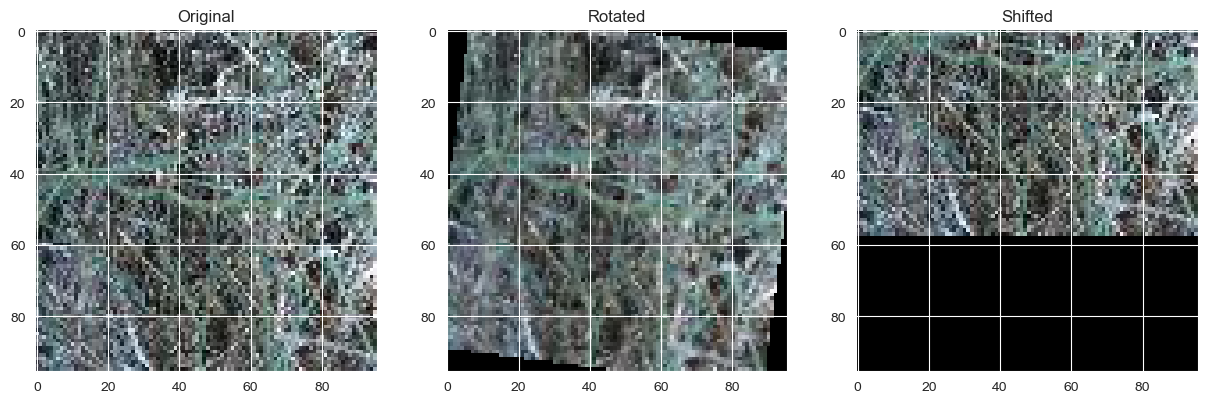

In [46]:
# Get random transformation
rot_t = rot_gen.get_random_transform(img_shape=(256, 256), seed=seed)
shift_t = shift_gen.get_random_transform(img_shape=(256, 256), seed=seed)
print("Transform:", rot_t)

# Apply the transformation
augmented = gen.apply_transform(image, rot_t)
augmented2 = gen.apply_transform(image, shift_t)


# Plot original and augmented images
fig, ax = plt.subplots(1, 3, figsize=(15,30))
ax[0].imshow(np.uint8(image))
ax[0].set_title("Original")
ax[1].imshow(np.uint8(augmented))
ax[1].set_title("Rotated")
ax[2].imshow(np.uint8(augmented2))
ax[2].set_title("Shifted")
plt.show()